In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from astropy import units as u
from astropy import constants as const

from bokeh.layouts import gridplot, row, Spacer
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Span
from bokeh.transform import linear_cmap

# File path
file_path = "exoplanets_eu.csv"
df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True)
display(df.head(5))

/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


name planet_status     mass  mass_error_min  mass_error_max  \
0  109 Psc b     Confirmed   5.7430         0.28900         0.28900   
1  112 Psc b     Confirmed   0.0330         0.00500         0.00500   
2  112 Psc c     Confirmed   9.8660         1.78100         1.78100   
3  11 Com Ab     Confirmed  16.1284         1.53491         1.53491   
4   11 UMi b     Confirmed  11.0873         1.10000         1.10000   

   mass_sini  mass_sini_error_min  mass_sini_error_max  radius  \
0     6.3830              0.07800              0.07800   1.152   
1     0.0330              0.00500              0.00500     NaN   
2        NaN                  NaN                  NaN     NaN   
3    16.1284              1.53491              1.53491     NaN   
4    11.0873              1.10000              1.10000     NaN   

   radius_error_min  ...  star_sp_type  star_age  star_age_error_min  \
0               NaN  ...         G5 IV      6.90                0.60   
1               NaN  ...          G0IV       NaN                 NaN   
2               NaN  ...          G0IV       NaN                 NaN   
3               NaN  ...         G8III       NaN                 NaN   
4               NaN  ...         K4III      1.56                0.54   

   star_age_error_max  star_teff  star_teff_error_min  star_teff_error_max  \
0                0.60     5600.0               80.000               80.000   
1                 NaN     5986.0              105.437              105.437   
2                 NaN     5986.0              105.437              105.437   
3                 NaN     4742.0              100.000              100.000   
4                0.54     4340.0               70.000               70.000   

   star_detected_disc  star_magnetic_field  star_alternate_names  
0                 NaN                  NaN              HD 10697  
1                 NaN                  NaN              HD 12235  
2                 NaN                  NaN              HD 12235  
3                 NaN                  NaN             HD 107383  
4                 NaN                  NaN                   NaN  

[5 rows x 98 columns]

In [3]:
df.columns

Index(['name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min',
       'tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min',
       'lambda_angle_error_max', 'impact_parameter',
       'impact_parameter_error_min', 'impa

In [4]:
df = df[['name','planet_status','mass','star_mass','star_distance','star_name',
    'radius','orbital_period','semi_major_axis',
    'detection_type','mass_measurement_type','ra', 'dec',
        'mag_v', 'mag_i', 'mag_j',
       'mag_h', 'mag_k']]

In [5]:
df['mass_measurement_type']
df['detection_type']

0       Radial Velocity, Astrometry
1                   Radial Velocity
2       Radial Velocity, Astrometry
3                   Radial Velocity
4                   Radial Velocity
                   ...             
7334                Primary Transit
7335                         Timing
7336                Primary Transit
7337                Primary Transit
7338                Primary Transit
Name: detection_type, Length: 7339, dtype: object

In [6]:
P = df['orbital_period'][df['detection_type']=='Microlensing']
mass_star = df['star_mass'][df['detection_type']=='Microlensing']
mass_planet = df['mass'][df['detection_type']=='Microlensing']
DL = df['star_distance']

In [7]:
i=0
ang_sep={}
mass_ratio = {}
for i in tqdm(range(len(df))):
    # print((not pd.isna(df['star_mass'].iloc[i])) and (not pd.isna(df['mass'].iloc[i])))
    # if (not pd.isna(df['star_mass'].iloc[i])) and (not pd.isna(df['mass'].iloc[i])) and (not pd.isna(df['star_distance'].iloc[i])) and (not pd.isna(df['semi_major_axis'].iloc[i])):
    mp = df['mass'].iloc[i]*u.M_jup
    ms = df['star_mass'].iloc[i]*u.M_sun
    m = mp+ms
    q = mp/ms
    mass_ratio[df['name'].iloc[i]]=q.decompose()
    dl = df['star_distance'].iloc[i]*u.pc
    # print(dl.to('kpc').value)
    if dl.to('kpc').value<8:
        ds = 8*u.kpc
    else:
        ds = dl + 500*u.pc
    pi_rel = 1/dl-1/ds
    a = df['semi_major_axis'].iloc[i] #[df['detection_type']=='Microlensing']
    k = 4*const.G/const.c**2
    theta_E = (np.sqrt(k*m*pi_rel).decompose())*(u.rad.to('uas'))
    alpha = (np.arctan(a*u.AU/dl).decompose()).to('uas').value
    s =(alpha/theta_E).decompose()
    ang_sep[df['name'].iloc[i]]=s
        

df['alpha']=df['name'].map(ang_sep)
df['mass_ratio']=df['name'].map(mass_ratio)




# fit_rr['p_value'] = fit_rr['Source'].map(p_value_dict)

100%|█████████████████████████████████████| 7339/7339 [00:03<00:00, 2076.50it/s]


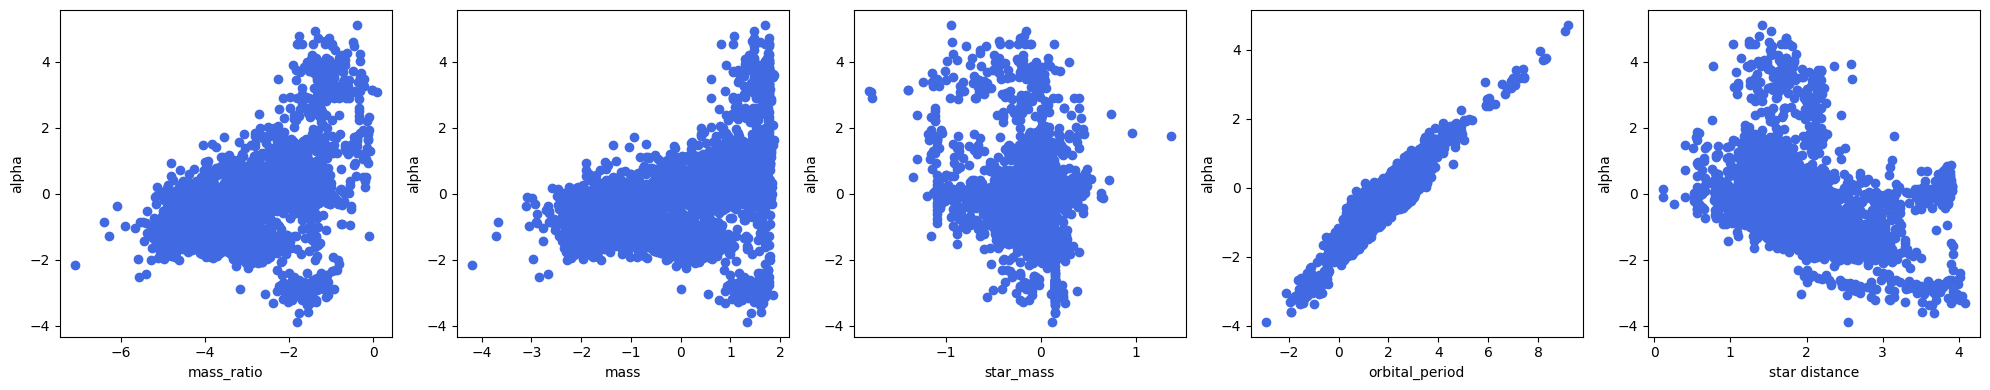

In [8]:

%matplotlib inline

def filter_nan(x, y):
    # Convert to numeric, forcing invalid values to NaN
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # Ensure data is converted to float (to avoid any type-related issues)
    x = x.astype(float).to_numpy()
    y = y.astype(float).to_numpy()
    
    # Create mask to filter out NaN values in both x and y
    mask = ~np.isnan(x) & ~np.isnan(y)
    return x[mask], y[mask], mask  # Return mask as well


# Create subplots in a single row (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

C='royalblue'

# Scatter plot 1: mass_ratio vs alpha
x, y,mask = filter_nan(df['mass_ratio'], df['alpha'])
axes[0].scatter(np.log10(x), np.log10(y),color=C)
axes[0].set_xlabel('mass_ratio')
axes[0].set_ylabel('alpha')

# Scatter plot 2: mass vs alpha
x, y,mask = filter_nan(df['mass'], df['alpha'])
# print(len(y))
axes[1].scatter(np.log10(x), np.log10(y),color=C)
axes[1].set_xlabel('mass')
axes[1].set_ylabel('alpha')

# Scatter plot 3: star_mass vs alpha
x, y,mask= filter_nan(df['star_mass'], df['alpha'])
axes[2].scatter(np.log10(x), np.log10(y),color=C)
axes[2].set_xlabel('star_mass')
axes[2].set_ylabel('alpha')

# Scatter plot 4: orbital_period vs alpha
x, y,mask = filter_nan(df['orbital_period'], df['alpha'])
axes[3].scatter(np.log10(x), np.log10(y),color=C)
axes[3].set_xlabel('orbital_period')
axes[3].set_ylabel('alpha')

# Scatter plot 5: star_distance vs alpha
x, y,mask= filter_nan(df['star_distance'], df['alpha'])
axes[4].scatter(np.log10(x), np.log10(y),color=C)
axes[4].set_xlabel('star distance')
axes[4].set_ylabel('alpha')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


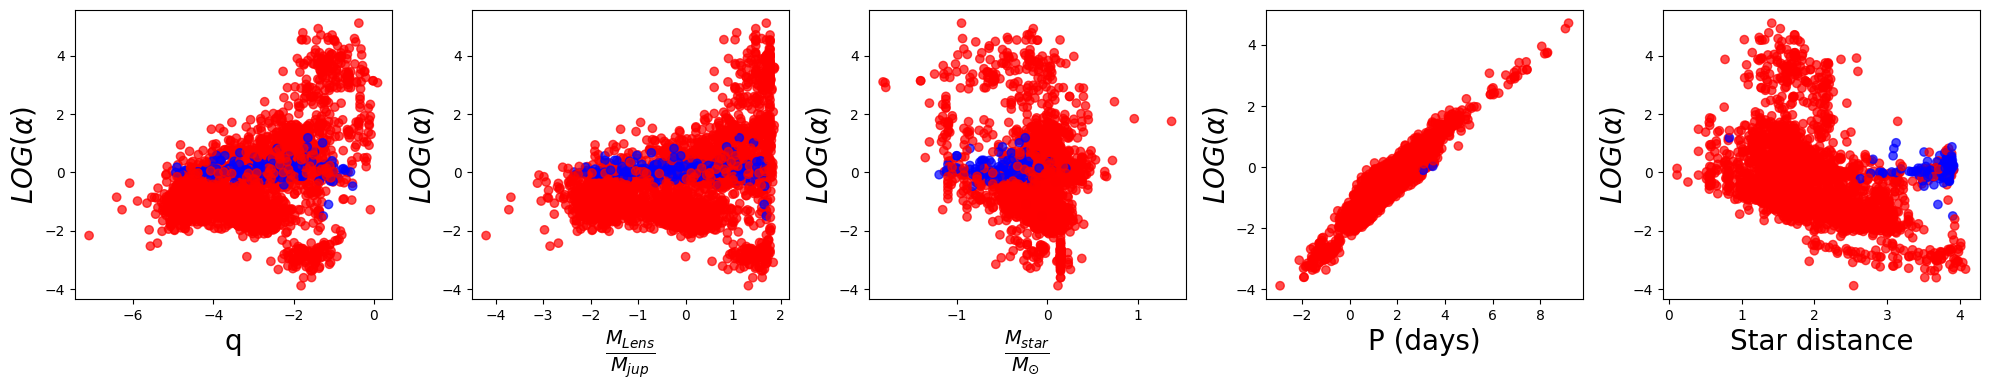

In [9]:


# Assume df is your DataFrame that includes the 'detection_type' column
# Create subplots in a single row (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Create a color mapping based on the detection type
colors = np.where(df['mass_measurement_type'] == 'Microlensing', 'blue', 'red')

# Scatter plot 1: mass_ratio vs alpha
x, y, mask = filter_nan(df['mass_ratio'], df['alpha'])
axes[0].scatter(np.log10(x), np.log10(y), color=colors[mask], alpha=0.7)  # Apply colors
axes[0].set_xlabel('q',fontsize=20)
axes[0].set_ylabel('$LOG(\\alpha)$',fontsize=20)

# Scatter plot 2: mass vs alpha
x, y, mask = filter_nan(df['mass'], df['alpha'])
axes[1].scatter(np.log10(x), np.log10(y), color=colors[mask], alpha=0.7)  # Apply colors
axes[1].set_xlabel(r'$\frac{M_{Lens}}{M_{jup}}$',fontsize=20)
axes[1].set_ylabel('$LOG(\\alpha)$',fontsize=20)

# Scatter plot 3: star_mass vs alpha
x, y, mask = filter_nan(df['star_mass'], df['alpha'])
axes[2].scatter(np.log10(x), np.log10(y), color=colors[mask], alpha=0.7)  # Apply colors
axes[2].set_xlabel(r'$\frac{M_{star}}{M_{\odot}}$',fontsize=20)
axes[2].set_ylabel('$LOG(\\alpha)$',fontsize=20)

# Scatter plot 4: orbital_period vs alpha
x, y, mask = filter_nan(df['orbital_period'], df['alpha'])
axes[3].scatter(np.log10(x), np.log10(y), color=colors[mask], alpha=0.7)  # Apply colors
axes[3].set_xlabel('P (days)',fontsize=20)
axes[3].set_ylabel('$LOG(\\alpha)$',fontsize=20)

# Scatter plot 5: star_distance vs alpha
x, y, mask = filter_nan(df['star_distance'], df['alpha'])
axes[4].scatter(np.log10(x), np.log10(y), color=colors[mask], alpha=0.7)  # Apply colors
axes[4].set_xlabel('Star distance',fontsize=20)
axes[4].set_ylabel('$LOG(\\alpha)$',fontsize=20)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [10]:
# df['mass']

In [11]:
# Display Bokeh plots inline (if using Jupyter)
output_notebook()

# Define colors for each technique
color_mapping = {
    'Astrometry': 'green',
    'Microlensing': 'blue',
    'Radial Velocity': 'red',
    'Spectrum': 'purple',
    'TTV': 'orange',
    'Theoretical': 'yellow',
    'Timing': 'brown',
    np.nan: 'gray'  # For missing values (NaN)
}

# Apply color mapping to 'mass_measurement_type'
df['color'] = df['mass_measurement_type'].map(color_mapping)

# Create Bokeh figures without legends

def create_scatter_plot(x, y, x_label, y_label, df, log_scale=True):
    x, y, mask = filter_nan(df[x], df[y])
    
    if log_scale:
        x = np.log10(x)
        y = np.log10(y)
    
    # Set fill_alpha based on detection type
    fill_alpha = np.where(df['mass_measurement_type'][mask] == 'Microlensing', 1.0, 0.3)  # 1.0 for Microlensing, 0.3 for others
    
    source = ColumnDataSource(data={
        'x': x,
        'y': y,
        'color': df['color'][mask],
        'name': df['name'][mask],  # Include the planet names for hover
        'mass': df['mass'][mask],  # Include the planet masses for hover
        'alternate_names': df['mass'][mask],
        # 'molecules': df['mass'][mask],
        'star_name': df['star_name'][mask],
        'ra': df['ra'][mask],
        'dec': df['dec'][mask],
        'detection_type': df['detection_type'][mask],
        'mass_measurement_type': df['mass_measurement_type'][mask],
        'fill_alpha': fill_alpha  # Add fill_alpha to the data source
    })
    
    p = figure(width=400, height=350, x_axis_label=x_label, y_axis_label=y_label)
    
    # Draw the scatter points
    p.circle('x', 'y', source=source, size=3, color='color', fill_alpha='fill_alpha')  # Use fill_alpha from the source
    
    # Add hover tool to display planet name
    hover = HoverTool()
    hover.tooltips = [("Planet Name", "@name"), ("Mass (M_jup)", "@mass"),("Detection type", "@detection_type"), ("Ra", "@ra"), ("Dec", "@dec")]  # Only display planet names
    p.add_tools(hover)
    
    # Add horizontal lines at α = 0.5 and α = 2
    hline1 = Span(location=np.log10(0.5), dimension='width', line_color='red', line_width=2, line_dash='dashed')
    hline2 = Span(location=np.log10(2), dimension='width', line_color='blue', line_width=2, line_dash='dashed')
    
    p.add_layout(hline1)
    p.add_layout(hline2)

    return p

p1 = create_scatter_plot('mass_ratio', 'alpha', 'q', r'$$LOG(\alpha)$$', df)
p2 = create_scatter_plot('mass', 'alpha', r'$$M_{Lens}/M_{jup}$$', r'$$LOG(\alpha)$$', df)
p3 = create_scatter_plot('star_mass', 'alpha', r'$$M_{star}/M_{\odot}$$', r'$$LOG(\alpha)$$', df)
p4 = create_scatter_plot('orbital_period', 'alpha', 'P (days)', r'$$LOG(\alpha)$$', df)
p5 = create_scatter_plot('star_distance', 'alpha', 'Star distance', r'$$LOG(\alpha)$$', df)

# Create the grid of plots
grid = gridplot([[p1, p2, p3, p4, p5]])

# Create a separate figure for the legend
legend_fig = figure(width=150, height=300, title="Mass Measurement Types", toolbar_location=None)

# Hide axes in the legend box
legend_fig.axis.visible = False
legend_fig.grid.visible = False

# Add dummy circles to display colors in the legend
for technique, color in color_mapping.items():
    if technique is np.nan:
        technique = 'Unknown'  # Replace NaN label with 'Unknown'
    r = legend_fig.circle(x=[0], y=[0], size=10, color=color, legend_label=str(technique))

legend_fig.legend.location = "center"
legend_fig.legend.label_text_font_size = "10pt"

# Add a spacer for custom padding between grid and legend
spacer = Spacer(width=10)

# Combine the grid of plots and the legend figure with the spacer in a row
layout = row(grid, spacer, legend_fig)

# Show the final layout
show(layout)


Loading BokehJS ...

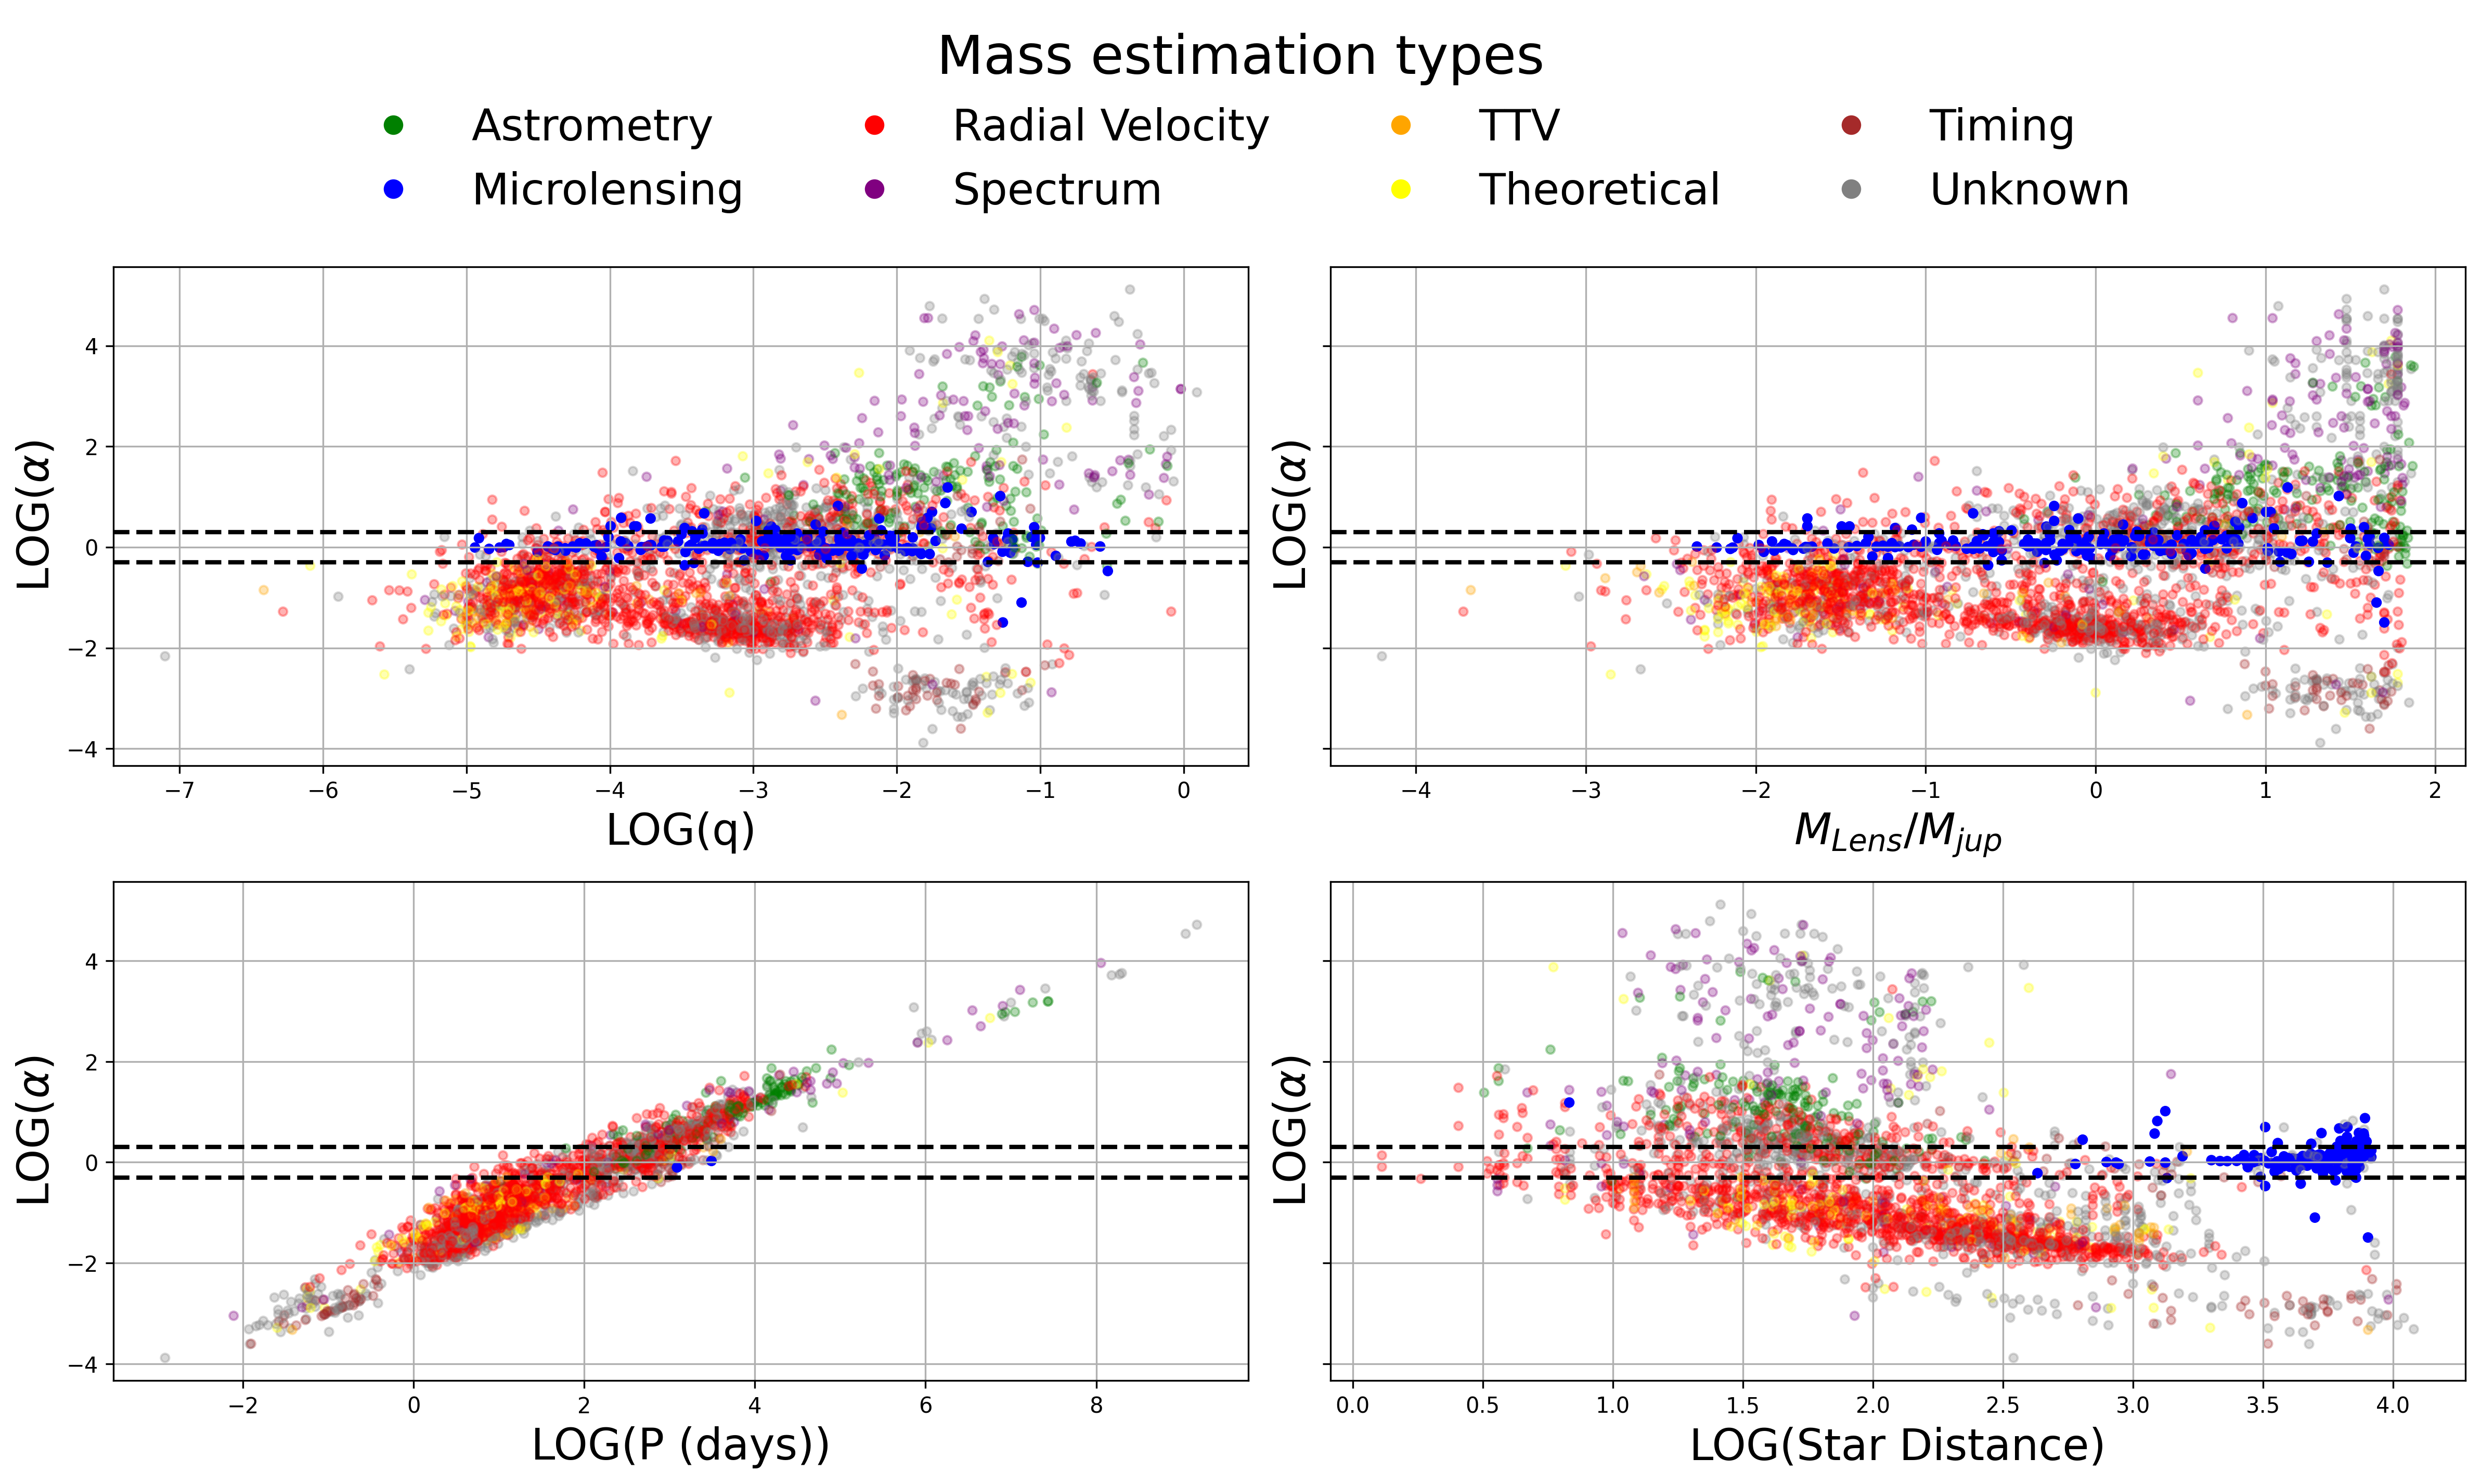

In [37]:
def create_scatter_plot(ax, x, y, x_label, y_label, df, log_scale=True):
    # Filter NaN values
    mask = ~df[[x, y]].isnull().any(axis=1)
    x_data = df.loc[mask, x]
    y_data = df.loc[mask, y]
    
    # Ensure x and y data are stripped of astropy.units.Quantity
    if hasattr(x_data.iloc[0], 'value'):
        x_data = x_data.apply(lambda v: v.value)  # Convert to numerical values
    if hasattr(y_data.iloc[0], 'value'):
        y_data = y_data.apply(lambda v: v.value)  # Convert to numerical values
    
    if log_scale:
        x_data = np.log10(x_data)
        y_data = np.log10(y_data)
    
    # Alpha values based on detection type
    alphas = np.where(df.loc[mask, 'mass_measurement_type'] == 'Microlensing', 1.0, 0.3)
    
    # Plot data
    scatter = ax.scatter(
        x_data, 
        y_data, 
        c=df.loc[mask, 'color'], 
        alpha=alphas, 
        s=15  # marker size
    )
    
    # Add horizontal dashed lines
    ax.axhline(y=np.log10(0.5), color='k', linestyle='dashed', linewidth=2)
    ax.axhline(y=np.log10(2), color='k', linestyle='dashed', linewidth=2)
    
    # Set labels
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.grid(True)

# Define colors for each technique
color_mapping = {
    'Astrometry': 'green',
    'Microlensing': 'blue',
    'Radial Velocity': 'red',
    'Spectrum': 'purple',
    'TTV': 'orange',
    'Theoretical': 'yellow',
    'Timing': 'brown',
    np.nan: 'gray'  # For missing values (NaN)
}

# Apply color mapping to 'mass_measurement_type'
df['color'] = df['mass_measurement_type'].map(color_mapping)

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True, dpi=300)

create_scatter_plot(axes[0,0], 'mass_ratio', 'alpha', 'LOG(q)', r'LOG($\alpha$)', df)
create_scatter_plot(axes[0,1], 'mass', 'alpha', '$M_{Lens}/M_{jup}$', r'LOG($\alpha$)', df)
# create_scatter_plot(axes[2], 'star_mass', 'alpha', '$LOG(M_{star}/M_{sun})$', 'LOG(alpha)', df)
create_scatter_plot(axes[1,0], 'orbital_period', 'alpha', 'LOG(P (days))', r'LOG($\alpha$)', df)
create_scatter_plot(axes[1,1], 'star_distance', 'alpha', 'LOG(Star Distance)', r'LOG($\alpha$)', df)

# Adjust layout
fig.tight_layout()

# Legend creation
legend_entries = []
for technique, color in color_mapping.items():
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=str(technique) if technique is not np.nan else 'Unknown'))


# loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
fig.legend(
    handles=legend_entries,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    title='Mass estimation types', fontsize=20, title_fontsize=25,ncols=4, frameon=False)
plt.savefig('planets.png',dpi=600,bbox_inches="tight")
# plt.tight_layout()
plt.show()


In [23]:
# Filter DataFrame for alpha between 0.2 and 0.4
df_filtered = df[(df['alpha'] > 0.2) & (df['alpha'] < 0.4)]

# Apply color mapping to 'mass_measurement_type'
df_filtered['color'] = df_filtered['mass_measurement_type'].map(color_mapping)

def create_scatter_plot(x, y, x_label, y_label, df, log_scale=True):
    x, y, mask = filter_nan(df[x], df[y])
    
    if log_scale:
        x = np.log10(x)
        y = np.log10(y)
    
    fill_alpha = np.where(df['mass_measurement_type'][mask] == 'Microlensing', 1.0, 0.3)
    
    source = ColumnDataSource(data={
        'x': x,
        'y': y,
        'color': df['color'][mask],
        'name': df['name'][mask],
        'mass': df['mass'][mask],
        'alternate_names': df['mass'][mask],
        'star_name': df['star_name'][mask],
        'ra': df['ra'][mask],
        'dec': df['dec'][mask],
        'detection_type': df['detection_type'][mask],
        'mass_measurement_type': df['mass_measurement_type'][mask],
        'fill_alpha': fill_alpha
    })
    
    p = figure(width=400, height=350, x_axis_label=x_label, y_axis_label=y_label)
    
    p.circle('x', 'y', source=source, size=8, color='color', fill_alpha='fill_alpha')
    
    hover = HoverTool()
    hover.tooltips = [("Planet Name", "@name"), ("Mass (M_jup)", "@mass"),
                      ("Detection type", "@detection_type"), ("Ra", "@ra"), ("Dec", "@dec")]
    p.add_tools(hover)

    hline1 = Span(location=np.log10(0.5), dimension='width', line_color='red', line_width=2, line_dash='dashed')
    hline2 = Span(location=np.log10(2), dimension='width', line_color='blue', line_width=2, line_dash='dashed')
    p.add_layout(hline1)
    p.add_layout(hline2)

    return p

# Create plots using the filtered DataFrame
p1 = create_scatter_plot('mass_ratio', 'alpha', 'q', r'$$LOG(\alpha)$$', df_filtered)
p2 = create_scatter_plot('mass', 'alpha', r'$$M_{Lens}/M_{jup}$$', r'$$LOG(\alpha)$$', df_filtered)
p3 = create_scatter_plot('star_mass', 'alpha', r'$$M_{star}/M_{\odot}$$', r'$$LOG(\alpha)$$', df_filtered)
p4 = create_scatter_plot('orbital_period', 'alpha', 'P (days)', r'$$LOG(\alpha)$$', df_filtered)
p5 = create_scatter_plot('star_distance', 'alpha', 'Star distance', r'$$LOG(\alpha)$$', df_filtered)

# The rest of the layout creation remains the same
grid = gridplot([[p1, p2, p3, p4, p5]])

legend_fig = figure(width=150, height=300, title="Mass Measurement Types", toolbar_location=None)
legend_fig.axis.visible = False
legend_fig.grid.visible = False

for technique, color in color_mapping.items():
    if technique is np.nan:
        technique = 'Unknown'
    legend_fig.circle(x=[0], y=[0], size=10, color=color, legend_label=str(technique))

legend_fig.legend.location = "center"
legend_fig.legend.label_text_font_size = "10pt"

spacer = Spacer(width=10)

layout = row(grid, spacer, legend_fig)

show(layout)


/tmp/ipykernel_92872/2998770501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['color'] = df_filtered['mass_measurement_type'].map(color_mapping)


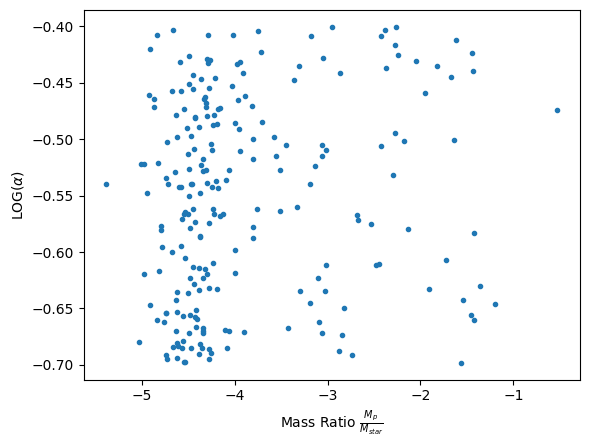

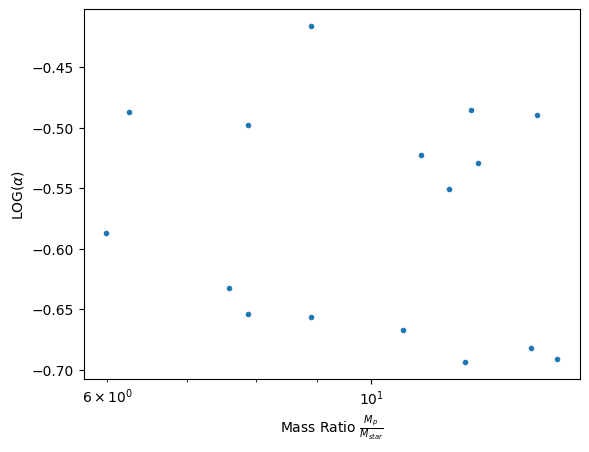

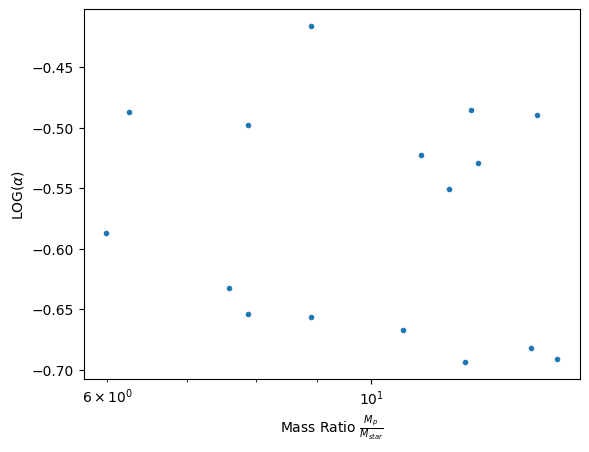

In [22]:
planets = df[(df["alpha"]<0.4) & (df["alpha"]>0.2)]
plt.plot(np.log10(planets['mass_ratio'].to_list()),np.log10(np.array(planets['alpha'].to_list())), marker='.',ls='')
plt.xlabel(r'Mass Ratio $\frac{M_p}{M_{star}}$')
plt.ylabel(r'LOG($\alpha$)')
plt.show()


plt.plot(planets['mag_i'],np.log10(np.array(planets['alpha'].to_list())), marker='.',ls='')
plt.xscale('log')
plt.xlabel(r'Mass Ratio $\frac{M_p}{M_{star}}$')
plt.ylabel(r'LOG($\alpha$)')
plt.show()

plt.show()
plt.plot(planets['mag_i'],np.log10(np.array(planets['alpha'].to_list())), marker='.',ls='')
plt.xscale('log')
plt.xlabel(r'Mass Ratio $\frac{M_p}{M_{star}}$')
plt.ylabel(r'LOG($\alpha$)')
plt.show()

In [14]:
# Extract values and units separately
df["log_alpha"] = np.log10(df["alpha"].apply(lambda x: x.value)) * df["alpha"].apply(lambda x: x.unit)
print("Number of planets")
print("")
print("LOG(0.2)<LOG(α)<LOG(0.4) :",len(df["log_alpha"][(df["log_alpha"]<np.log10(0.4)) & (df["log_alpha"]>np.log10(0.2))]))
# print("LOG(α)<-1    :",len(df["log_alpha"][df["log_alpha"]<np.log10(-1)]))
print("LOG(α)<LOG(0.2)     :",len(df["log_alpha"][df["log_alpha"]>np.log10(0.2)]))
print("LOG(α)>LOG(0.4)   :",len(df["log_alpha"][df["log_alpha"]<np.log10(0.4)]))

Number of planets

LOG(0.2)<LOG(α)<LOG(0.4) : 227
LOG(α)<LOG(0.2)     : 1664
LOG(α)>LOG(0.4)   : 1610


In [15]:
nan_count = df["log_alpha"][df["log_alpha"].isna()]
print(nan_count)

Series([], Name: log_alpha, dtype: object)


In [16]:
# Count NaN values using np.isnan after removing units if applicable
nan_count = df["log_alpha"].apply(lambda x: np.isnan(x.value) if hasattr(x, 'value') else np.isnan(x)).sum()
print("Number of NaNs:", nan_count)


Number of NaNs: 4292


In [17]:
from bokeh.io import export_png
from bokeh.layouts import row, gridplot
from bokeh.models import Spacer
from selenium import webdriver

# Same plot creation code as before ...

# Combine the grid of plots and the legend figure with the spacer in a row
layout = row(grid, spacer, legend_fig)

# Show the final layout (optional if you want to see it in the notebook)
show(layout)

# Export the layout as a high-resolution PNG
export_png(layout, filename="high_res_figure.png")


RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

In [ ]:
# Create the grid of plots
grid = gridplot([[p1, p2, p3, p4, p5]])

# Create a separate figure for the legend
legend_fig = figure(width=150, height=250, title="Mass Measurement Types", toolbar_location=None)

# Hide axes in the legend box
legend_fig.axis.visible = False
legend_fig.grid.visible = False

# Add dummy circles to display colors in the legend
for technique, color in color_mapping.items():
    if technique is np.nan:
        technique = 'Unknown'  # Replace NaN label with 'Unknown'
    r = legend_fig.circle(x=[0], y=[0], size=10, color=color, legend_label=str(technique))

legend_fig.legend.location = "center"
legend_fig.legend.label_text_font_size = "10pt"

# Combine the grid of plots and the legend figure in a row with adjustable padding
layout = row(grid, legend_fig, sizing_mode='stretch_both')

# Show the final layout
show(layout)


In [ ]:
# df['detection_type']

In [ ]:
# df['detection_type']
# df

In [ ]:
(df.columns).to_list()

# We can check how many planets are in common with the Nasa Exoplanet Archive

In [ ]:
import pandas as pd
# File path
file_path = "ML_2024.10.15_10.57.52.csv"
# Reading the CSV file with proper handling of quotes and commas
df = pd.read_csv(file_path, quotechar='"', comment='#', skipinitialspace=True)
# Display the dataframe to check if it's read correctly
display(df.head())
df.columns

In [ ]:
df['ml_massratio']=df['ml_massratio']*1e-4
df['ml_massratio']

In [ ]:
df['htmllink'][0]

In [ ]:

# len(df)

# DS
# df

from tqdm.auto import tqdm
i=0
# a = 
ang_sep={}
mass_ratio = {}
mass_star = {}
for i in tqdm(range(len(df))):
    mp = df['pl_massj'].iloc[i]*u.M_jup
    m = df['st_mass'].iloc[i]*u.M_sun#mp+ms
    q = df['ml_massratio'].iloc[i]#mp/ms
    m_star = m/(1+q)
    
    mass_star['pl_name']=m_star
    ds = df['ml_dists'].iloc[i]*u.pc
    dl = df['sy_dist'].iloc[i]*u.pc
    a = df['pl_orbsmax'].iloc[i]*u.AU#df['semi_major_axis'][df['detection_type']=='Microlensing'].iloc[0]
    k = 4*const.G/const.c**2
    
    pi_rel=1/dl-1/ds
    theta_E = (np.sqrt(k*m*pi_rel)*u.rad.to('mas')).decompose()
    # print(theta_E.decompose())
    # print(ds)
    # theta_E = df['ml_radeinang'].iloc[i]#(np.sqrt(k*m*pi_rel).decompose())*(u.rad.to('uas'))
    alpha = (np.arctan(a/dl).decompose()).to('mas').value
    
    s = alpha/theta_E
    # print(s)
    ang_sep[df['pl_name'].iloc[i]]=s
        
    # elif 
# print(ang_sep)

df['alpha']=df['pl_name'].map(ang_sep)
df['mass_ratio']=df['pl_name'].map(mass_ratio)

In [ ]:
# set(df['alpha'])

In [ ]:

# file_path = "ML_2024.10.15_10.57.52.csv"
# df2 = pd.read_csv(file_path, quotechar='"', comment='#', skipinitialspace=True)['pl_name'].values
# file_path = "exoplanets_eu.csv"
# df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True)['name'].values
# # df2
# # df

In [ ]:
# # Convert the arrays to sets and find the intersection
# repeated_strings = set(df2) & set(df)

# # Print the result
# print(f"Repeated events: {repeated_strings}")

# print(f"Number of events: {len(repeated_strings)}")